# **Bienvenido**
**Clasificaci√≥n de preguntas de clientes - Santander üèÖ TOP 3** 

Este colab te lleva a explorar los modelos NLP que me ayudaron a clasificar miles
de preguntas en m√°s de 300 categor√≠as diferentes.


# Introducci√≥n

Luego de varias semanas,  el esfuerzo trajo frutos, un d√≠a antes de finalizar la competencia logr√© posicionarme en el top 10, y luego de varios intentos (muchos) logr√© afinar mis par√°metros y modelos para posicionarme en el top 3. 

Una competencia desafiante y que disfrut√© mucho. Estoy muy agredecido con todos los involucrados en la organizaci√≥n de este tipo de competencias y en especial con todos los que me apoyaron a seguir intentando.


# **Exploraci√≥n de los datos üî¨**

Antes de describir paso a paso todas las etapas de mi estrategia es necesario echar un vistazo a los datos.

In [2]:
# Descargamos y leemos los datos de entrenamiento
!wget -q -O train.csv https://drive.google.com/u/0/uc?id=1SvVbsYUpKphC3NuU4y7JDYsDJxYT61Yl&export=download
import pandas as pd

train_data = pd.read_csv('train.csv', sep='|')
train_size = len(train_data)
train_data.head(5)

Pregunta Intencion
0               como puedo trabajar en santander rio   Cat_102
1                pagar tarjeta visa querer reintegro   Cat_350
2                      pagar tarjeta naranja sistema   Cat_132
3  no se debit√≥ la primera cuota del plan de bien...   Cat_129
4                             abonar tarjeta credito   Cat_342

## Informaci√≥n sobre las clases:
Vamos a conocer la distribuci√≥n de las clases:

In [3]:
print('Total de clases: ' , len(train_data['Intencion'].unique()))

Total de clases:  352


In [4]:
category_freq = train_data['Intencion'].value_counts()
category_freq = pd.DataFrame({'n':  category_freq.values, 'Percentage': category_freq.apply(lambda x: '{0} %'.format(x*100/train_size))})

print('Cantidad de preguntas por clase')
print(category_freq.head(3), '\n...\n')
print(category_freq.tail(3))

Cantidad de preguntas por clase
           n            Percentage
Cat_132  600  2.9844807003581377 %
Cat_293  567    2.82033426183844 %
Cat_1    493  2.4522483087942697 % 
...

         n              Percentage
Cat_205  3  0.014922403501790688 %
Cat_24   2  0.009948269001193792 %
Cat_104  1  0.004974134500596896 %


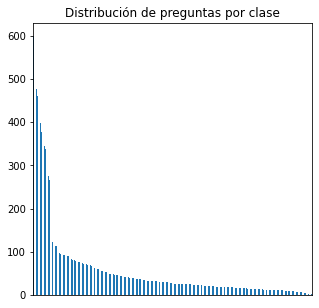

In [5]:
import matplotlib
%matplotlib inline

fig, axes = matplotlib.pyplot.subplots(figsize=(5, 5), nrows=1, ncols=1)
category_freq['n'].plot(kind='bar', title='Distribuci√≥n de preguntas por clase').get_xaxis().set_ticks([]);

‚ö†Ô∏è La categor√≠a con m√°s preguntas posee 600 entradas, mientras que la categor√≠a con menos preguntas posee s√≥lo 1. El dataset est√° muy desbalanceado como podemos observar en la gr√°fica anterior.

A partir de esta informaci√≥n podemos considerar estrat√©gias para lidiar con datasets desbalanceados.

## Informaci√≥n sobre las preguntas

Tambi√©n podemos obtener informaci√≥n acerca de las preguntas, para conocer un poco m√°s el dataset

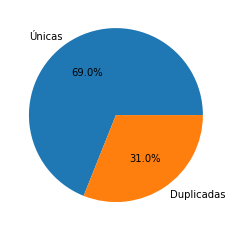

In [6]:
unique_q = train_data.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) == 1)
duplicate_q = train_data.groupby(["Pregunta", 'Intencion']).filter(lambda x: len(x) > 1)
matplotlib.pyplot.pie((len(unique_q)*100/train_size, len(duplicate_q)*100/train_size),
                            labels=['√önicas', 'Duplicadas'],
                            autopct='%1.1f%%');

Aunque un 31% del dataset son preguntas repetidas, entrenar con o sin las preguntas repetidas no afect√≥ considerablemente el performance de los modelos.

Ahora vamos a explorar la distribuci√≥n de palabras y caracteres dentro de las preguntas:

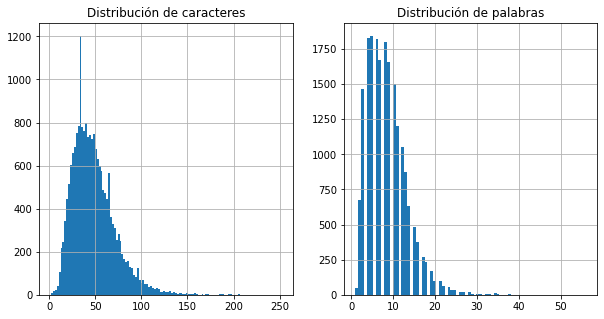

In [7]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

train_data['length'] = train_data['Pregunta'].apply(len)
train_data['length_tokens'] = train_data['Pregunta'].apply(lambda x : len(tokenizer.tokenize(x)))

fig, axes = matplotlib.pyplot.subplots(figsize=(10, 5), nrows=1, ncols=2)

train_data['length'].hist(bins=121, ax=axes[0]);
train_data['length_tokens'].hist(bins=80, ax=axes[1]);

axes[0].title.set_text('Distribuci√≥n de caracteres');
axes[1].title.set_text('Distribuci√≥n de palabras');

Esta informaci√≥n es √∫til para conocer la cantidad de tokens y posteriormente limitar la representaci√≥n num√©rica de las preguntas.

## Contenido de las preguntas
Ahora echemos un vistazo a las palabras con m√°s y menos frecuencia

In [8]:
!pip install wordcloud

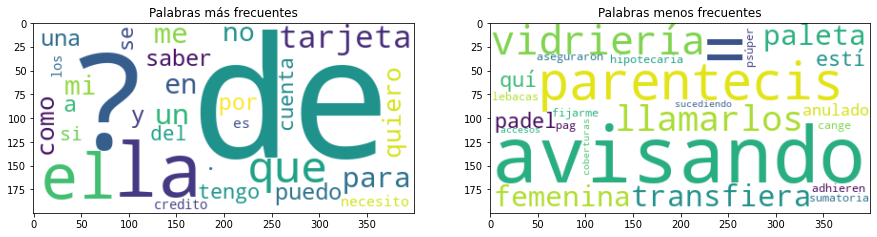

In [9]:
from wordcloud import WordCloud

from collections import Counter
train_data['tokens'] = train_data['Pregunta'].apply(lambda x : tokenizer.tokenize(x))
dic = Counter()

for tokens in train_data.tokens.values:
  dic.update(tokens)

def getWordcloud(data):
  return WordCloud(background_color ='white', min_font_size = 10).generate_from_frequencies(data)

wordcloud1 = getWordcloud(dict(dic.most_common(30)))
wordcloud2 = getWordcloud(dict(dic.most_common()[-30:]))

fig, axes = matplotlib.pyplot.subplots(figsize=(15, 15), nrows=1, ncols=2)
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[1].imshow(wordcloud2, interpolation='bilinear')

axes[0].title.set_text('Palabras m√°s frecuentes')
axes[1].title.set_text('Palabras menos frecuentes')

Esto nos brinda informaci√≥n sobre qu√© palabras podemos descartar, as√≠ como la presencia de stop words en el dataset.


---


Ahora, como parte de la exploraci√≥n, el siguiente paso fue explorar la relaci√≥n entre las palabras.

Para ello voy a utilizar Gensim y Fastext

In [10]:
import gensim
model_words = gensim.models.FastText(sentences=train_data.tokens.values, min_count=5, size=100, workers=3, window=5, sg=1)

Con el modelo entrenado, ahora podemos hacer preguntas interesantes como por ejemplo, palabras similares

In [11]:
model_words.wv.most_similar('credito', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ccredito', 0.9579350352287292),
 ('cred', 0.9370944499969482),
 ('credit', 0.9251407384872437),
 ('cr√©dito', 0.9221587777137756),
 ('dito', 0.9074308276176453)]

In [12]:
model_words.wv.most_similar('banking', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bankin', 0.9960318803787231),
 ('hombanking', 0.9918783903121948),
 ('bankig', 0.9900574088096619),
 ('homebanking', 0.9838123321533203),
 ('onlinebanking', 0.9715108275413513)]

Esta relaci√≥n entre palabras nos da ideas de los errores m√°s comunes que cometen los clientes al formular las preguntas, m√°s adelante veremos como usamos esta informaci√≥n como parte de una estrategia para mejorar los modelos.



---

Como resultado del analisis anterior tambi√©n ser√≠a interesante encontrar qu√© tanto est√° cubierto nuestro universo de palabras en un cuerpo pre entrenado. Es decir, cuantas de las palabras escritas en las preguntas aparecen en el vocabulario de modelos entrenados en cuerpos como Wikipedia, en este caso utilizaremos: Spanish Billion Word Corpus and Embeddings


In [13]:
# FastText embeddings from SBWC 300dm
!wget -q --no-clobber http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz
!gunzip fasttext-sbwc.vec.gz

In [14]:
import numpy as np
MATRIX_VECTOR = 'fasttext-sbwc.vec'
embeddings_index = {}

f = open(MATRIX_VECTOR,  'r', encoding='utf-8')
for i, line in enumerate(f):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

Ahora que contamos con el vocabulario preentrenado, podemos ver cuales de nuestras palabras aparecen en √©l y cu√°les no:

In [15]:
unknown_words = []
for word, i  in dic.items():
  if embeddings_index.get(word) is None: 
    unknown_words.append(word)

print('Palabras desconocidas:')
for word_index in range(min(len(unknown_words), 15)):
  print(unknown_words[word_index])

print('\nTotal: ', len(unknown_words), ' of ', len(dic.items()), '. Coverage: ', (len(dic.items())-len(unknown_words))*100/len(dic.items()), '%')

Palabras desconocidas:
?
hombamnkin
.
ayud√°s
invercion
hablilitacion
ccredito
dnrap
buscartenencias
conumos
25
%.
!
depocitaron
aadnatage_

Total:  859  of  6342 . Coverage:  86.45537685272785 %


Como podemos observar este m√©todo nos ayuda a encontrar errores en las preguntas, as√≠ como las palabras √∫nicas del dataset. Adem√°s nos informa que m√°s del 80% de las palabras del dataset se encuentran en el vocabulario de SBWC.

## Conclusiones de la exploraci√≥n de datos üìÉ


üìå El dataset est√° desbalanceado.

üìå Existe una gran cantidad de preguntas repetidas, con igual intenci√≥n y con diferente intenci√≥n.

üìå La cantidad de caracteres por pregunta ronda aproximadamente entre (40, 60).

üìå La cantidad de palabras por pregunta ronda aproximadamente entre (8, 15).

üìå Existe una gran cantidad de stopwords frecuentes.

üìå Existen palabras con frecuencia 1, que posiblemente no sean representativas.

üìå Existen signos de puntuaci√≥n, algunas palabras llevan tilde y otras no.

üìå Algunas palabras similares se deben a errores ortogr√°ficos.

üìå 80% De las palabras existen en un cuerpo pre entrenado


# Estrategia ‚öîÔ∏è
Mi peque√±a experiencia en competencias similares de clasificaci√≥n de texto me sirvieron como base para atacar el problema, realic√© una etapa de procesamiento luego entren√© modelos utilizando Redes Neuronales Recurrentes y la cereza del pastel, un modelo utilizando BERT (Bidirectional Encoder Representations from Transformers) pre entrenado en espa√±ol (BETO)


Describo el flujo de esta estrategia en el siguiente gr√°fico:

<br />

<img src="https://i.imgur.com/VtKd7pK.png"/> 




# Etapa 1: Preprocesamiento üî®

### Preprocesamiento para Redes Neuronales Recurrentes:
En base al an√°lisis anterior realic√© un preprocesamiento que minimizaba la cantidad de entradas en el diccionario y normalizaba todas las palabras en las preguntas. Este pipeline fue evolucionando de acuerdo a los resultados de entrenamiento, por ejemplo, aunque hay una gran cantidad de stopwords, entrenar el modelo sin stopwords desminuy√≥ la efectividad del mismo por lo tanto se conservan.

<br />

<img src="https://i.imgur.com/1HKXMF1.png" width="400"/>

<br />

## Preprocesamiento para BERT:
Luego de varias pruebas, conclu√≠ que el mejor resultado lo obten√≠a si no aplicaba ning√∫n cambio sobre las palabras excepto por el Tokenizer pre entrenado en BETO. El mismo se encarga de normalizar y hacer lowercase de las palabras, as√≠ como agregar los separadores y m√°scaras correspondientes.

<br />

<img src="https://i.imgur.com/54rO7T9.png" width="400" />

<br />



# **Etapa 2: Entrenamiento üö¥**

## Intentos previos:
**El primer intento:**
Mi primer intento lo llev√© a cabo utilizando un modelo perceptron multicapa bastante simple, donde los features era n-gram vectors computados usando TFIDF que fueron obtenidos luego de limpiar los datos basandome en el an√°lisis anterior. Sin embargo no logr√© obtener un score mayor a **0.70**.

**El segundo:**
Mi segundo intento fue hecho con Embeddings, donde us√© como base un modelo que hice anteriormente para la clasificaci√≥n de t√≠tulos en la competencia de Mercadolibre de 2019, con este modelo logr√© alcanzar el puesto 18 de un total de 219 participantes en dicha competencia. 

Al usar Embeddings logr√© alcanzar un puntaje de **0.78**. Al parecer Word Embeddings era una estrat√©gia que podr√≠a rendir frutos, luego de sucesivos env√≠os utilizando Embeddings pre entrenados en distintos cuerpos en espa√±ol, conclu√≠ que el mejor modelo que obtuve fue entrenando mis propios Embeddings.

Todos los modelos de embeddings utilizaron el pre procesamiento descrito anteriormente.

**Tabla de puntajes para los modelos iniciales:**

Modelo | Balanced Accuracy
-- | --
n-grams | **0.70**
Embeddings | **0.78**

## Modelos LSTM y GRU
Luego de investigar c√≥mo mejorar el rendimiento del modelo qu√© solo usaba Embeddings y una capa clasificadora, introduje una capa LSTM y GRU en dos modelos en paralelo, esto me catapult√≥ al top 15.

Arquitectura de los modelos GRU y LSTM (Alrededor de **1,526,472** par√°metros):

<img src="https://i.imgur.com/MT21cDo.png" width="300"/>


**Tabla de puntajes para los mejores modelos individuales basados en Word Embeddings**

<br /> 


Modelo | Balanced Accuracy
-- | --
Embeddings | **0.78**
Embeddings + Bidirectional LSTM | **0.8071**
Embeddings + Bidirectional GRU | **0.8056**

## BERT üçí
Mi ultima esperanza para romper el techo alcanzado por RNN, utilic√© BERT (Alrededor de **110,121,568** par√°metros) pre entrenado en espa√±ol (BETO)

<br />
<img src="https://i.imgur.com/a5vjwHu.png" width="130" />

Mi mejor puntaje obtenido para BERT fue de **0.8447**


## **Sobre las observaciones del dataset**
Gran parte de la informaci√≥n obtenida en el an√°lisis de datos sirvi√≥ como base para decidir el preprocesamiento a usar en el entrenamiento de los modelos. Aunque no todas las conclusiones aportaron directamente en el preprocesamiento, sirvieron como pistas para conocer qu√© informaci√≥n es m√°s valiosa en el dataset.

## **Sobre el entrenamiento**
Los modelos basados en RNN fueron entrenados utilizando KFolds, espec√≠ficamente StratifiedKFold, una variaci√≥n que conserva las proporciones de las clases ya que como descubrimos en la exploraci√≥n de datos el dataset est√° bastante desbalanceado, junto a la ayuda de Sklearn calcul√© los pesos por clase para penalizar las clases con menor o mayor representaci√≥n. Realic√© 10 folds, lo que divide el dataset en 1/10 para validar y 9/10 para entrenar por fold. Obteniendo as√≠ un Balanced Accuracy en promedio de **0.80** para ambos modelos basados en RNN.


---
Al igual que los otros modelos entren√© BERT utilizando KFolds, esto se tom√≥ su tiempo a√∫n utilizando TPUs.

Para detener el entrenamiento de todos los modelos utilic√© Early Stopping, basandome en el mejor validation accuracy del mismo y guardando los mejores pesos. 


Una vez identificado un buen par√°metro para el n√∫mero de √©pocas y el learning rate de los mejores modelos, entren√© los modelos con todo el dataset, sin separar entre training y validation, esto tiene sus pros y contras, sin embargo con el prop√≥sito de la competencia result√≥ en un mejor performance en el leaderboard.


## Gr√°ficos de Entrenamiento para 1 fold

## Accuracy:


<table>
  <tr>
    <td>
      <div>
      <div>LSTM</div>
      <div><img src="https://i.imgur.com/DOcYN55.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>GRU</div>
      <div><img src="https://i.imgur.com/F0y6nxp.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>BERT</div>
      <div><img src="https://i.imgur.com/dlHbnT6.png" width="400"></div>
      </div>
    </td>
   </tr> 
</table>

## Loss:


<table>
  <tr>
    <td>
      <div>
      <div>LSTM</div>
      <div><img src="https://i.imgur.com/ZpFbBaq.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>GRU</div>
      <div><img src="https://i.imgur.com/zOL5XyL.png" width="400"></div>
      </div>
    </td>
    <td>
      <div>
      <div>BERT</div>
      <div><img src="https://i.imgur.com/hxH4FeZ.png" width="400"></div>
      </div>
    </td> 
</table>

## **Selecci√≥n de Hyperparametros**

Para encontrar los **hyperparametros** que mejor resultado me brindaron entren√© m√°s de 50 modelos realizando grid search con diferentes valores, tanto en Kaggle como en Google Colab.

Fue un gran reto encontrar los valores que evitaran overfittear los modelos pero que me brindaran una puntaci√≥n estable, por otro lado tuve que luchar contra los n√∫meros random ya que ni en Google Colab, ni en Kaggle pude fijarlos.

## Para Redes Neuronales Recurrentes:
Represent√© los tokens en **120** dimensiones, tanto LSTM como GRU contienen como units el doble de dimensiones de la capa de Embeddings.

La capa densa intermedia contiene **512** units, con la funci√≥n Relu.

Adem√°s limit√© el largo de las palabras a **30**, y agregu√© padding a las palabras con menor cantidad. Conserv√© cada palabra del diccionario, incluso aquellas con frecuencia igual a 1.

Como optimizador us√© **Adam** con un learning rate igual a **0.0001**. 

## Para BERT:
No logr√© utilizar Weight Decay Regularization, sin embargo fijar el learning rate en un valor igual a **3e-5** me di√≥ buenos resultados. De igual forma limit√© las palabras a un largo de 30. Prob√© con distintos valores para la capa Dropout y **0.35** result√≥ ser un buen n√∫mero Al igual que para RNN el optimizador que us√© fue **Adam**.



# **Etapa 3: Predicci√≥n üîÆ**

Un dia antes de finalizar la competencia prob√© mi ultima opci√≥n, **ensamblar** los distintos modelos, esto me funcion√≥ en una competencia de clasificaci√≥n de audio para la Universidad Nacional del Litoral donde logr√© obtener el segundo lugar.

Mi primer ensamblaje consisti√≥ en mi mejor modelo basado en LSTM junto a mi mejor modelo basado en BERT con 0.5 de peso cada uno:

`Assembled = BERT * 0.5 + LSTM * 0.5`

El resultado fue ir directo al top 10, un balanced accuracy de **0.8533** üéâ

Luego de esto segu√≠ mejorando los modelos individuales y arm√© el ensamblado final el cual consisti√≥ en lo siguiente:

Modelo | Weight | Individual Score
-- | -- | -- |
Embeddings + Bidirectional LSTM | 0.3 | 0.8071668160237432
Embeddings + Bidirectional GRU | 0.2 | 0.8056236171806629
BERT | 0.5 | 0.8447457866471272

Esto es:

`Assembled2 = BERT * 0.5 + LSTM * 0.3 + GRU * 0.2`


Y el resultado final: 

.
.
.
.

## Un Balanced Accuracy de **0.8663** == Top 3 en el public leaderboard.

# **Intentos de optimizaci√≥n üõ∏**
Durante el entrenamiento de los modelos desaroll√© varias soluciones para intentar mejorar la calidad de los modelos, las cuales listo a continuaci√≥n:

* **Hierarchical classification**

  Intent√© agrupar las categor√≠as con menor presencia en una un√≠ca categor√≠a, y as√≠ entrenar un modelo (n-k)+1 donde n es el numero total de categor√≠as y k es la cantidad de categor√≠as con menos presencia. Posteriormente intentar crear un clasificador especializado en las k categorias con menor representaci√≥n. Sin embargo este approach no result√≥.
*  **Fine Tunning y Transfer Learning con Word Embeddings Existentes**

  Intent√© congelar la primera capa de mis modelos LSTM y GRU. Y usar los pesos inicializados con los valores existentes en cuerpos pre entrenados como SBWC, logr√© un BACC de 0.75, posteriormente descongel√© la capa e intent√© entrenar de nuevo, sin embargo no logr√© mejorar este score. 

*   **Correcci√≥n autom√°tica de errores ortogr√°ficos utilizando Levenshtein distance**

  Este approach no funcion√≥ del todo ya que existen muchas palabras √∫nicas en el dataset, y una gran cantidad de errores son practicamente indescifrables. Hacer una correcci√≥n manual de los errores m√°s frecuentes podr√≠a mejorar el rendimiento.

* **Words embeddings usando Train y Test dataset**

  Intente entrenar mi propio modelo Fastext para usar Word Embeddings y hacer fine-tuning utilizando palabras del train y el test dataset. Sin embargo este approach no di√≥ buenos resultados.

* **Agregar m√°s capas a BERT**

  Intent√© combinar varias arquitecturas usando como capa previa a BERT sin embargo no tuve buenos resultados.

* **Contextual augmentation**

  Intente crear preguntas a partir de modelos como el mismo BERT, donde el objetivo era agregar o reemplazar una palabra de las preguntas basandome en el contexto, este approach no mejor√≥ significativamente el score.

  La pregunta "**cu√°les son los requisitos para obtener un pr√©stamo?**" se convert√≠a en:
  
  *cu√°les son los requisitos para poder obtener un nuevo pr√©stamo ?*


*   **Intentar balancear el dataset creando preguntas**

  Desarroll√© un pipeline de traducci√≥n descrito a continuaci√≥n

  <img src="https://i.imgur.com/qwmPQkh.png" width="250"/>

 
  Este algoritmo convert√≠a la frase: 
  
  **c√≥mo puedo hacer para enviarles mi curr√≠culum?**


  En las siguientes frases:
  - *¬øC√≥mo puedo enviarte mi CV?*
  - *¬øC√≥mo puedo enviar mi curr√≠culum?*
  - *¬øC√≥mo puedo enviarle mi CV?*

Sin embargo no todas las traducciones fueron tan buenas y no logr√© obtener un buen score usanto esta t√©cnica.

# **Pr√≥ximos pasos y posibles mejoras**
* Implementar AdamW y encontrar una mejor combinaci√≥n de valores para el learning rate de BERT puede ayudar ganar un mejor valor en el entrenamiento.

* Para los modelos LSTM es posible utilizar los datos de Word Embeddings para corregir los errores ortogr√°ficos presentes y disminu√≠r m√°s el diccionario.

* Encontrar mejores valores para los pesos de los modelos ensamblados utilizando una funcion que minimice el loss en las predicciones de los modelos.

* Es posible que alguna de las t√©cnicas usadas como la de traducci√≥n funcione para augmentar el dataset, ya que un solo sample para una clase no es suficiente para entrenar.

* Me gustar√≠a haber intentado invertir m√°s tiempo en mejorar los modelos que en lidiar con el desbalance y la falta de ejemplos en las clases. Porque el modelo final deja casi intacto el dataset.

* Con algo m√°s de tiempo tambi√©n se podr√≠a obtener m√°s informaci√≥n sobre las palabras del set de prueba, con la intenci√≥n de mejorar el modelo.


# **El valor que aporta mi soluci√≥n**
  A trav√©s de la concepci√≥n de la soluci√≥n en s√≠, fu√≠ descubriendo informaci√≥n que puede ser √∫til para abordar futuros problemas de clasificaci√≥n, por otro lado, los defectos encontrados en los modelos as√≠ como las ideas, sirven como punto de inicio para mejorar modelos existentes o iterar sobre el dataset para mejorarlo y as√≠ construir un modelo que logre generalizar mucho m√°s y sea totalmente confiable en un ambiente de producci√≥n. Por mi parte esta soluci√≥n forma parte de una etapa de aprendizaje que me ha llevado a descubrir y explorar nuevos conocimientos en cuanto al campo de NLP.

# **Conclusiones**

Siempre es importante apuntar a un modelo que generalize de la mejor manera, fue un reto lidiar con el dataset, que aunque es chico, presenta distintas complicaciones. Entrenar con todo el dataset no es recomendado en modelos que requieran posterior observaci√≥n o cuyo prop√≥sito sea ser desplegados en aplicaciones para la vida real, es decir, deban ser calificados en tiempo real con datos nuevos, sin embargo debido a la poca representaci√≥n de algunas clases, usar esta t√©cnica sirvi√≥ para prop√≥sitos de la competencia.

La exploraci√≥n de m√©todos para augmentar, limpiar y mejorar el dataset son la fundaci√≥n y las bases de los ajustes para la posterior decisi√≥n de los modelos utilizados, por otro lado, haciendo uso de GPU's y TPU's se pueden lograr entrenar modelos en paralelo mediante plataformas como Google Colaboratory con el fin de encontrar los mejores valores para los hyperparametros.

Finalmente el ensemble de modelos juega un rol crucial en esta soluci√≥n, ya que si cada modelo se aproxima por un lugar distinto a la soluci√≥n, al unirlos utilizando Weighted Average Ensemble, en teoria estar√≠amos acercandonos a la soluci√≥n final gracias al ensamble realizado con los pesos propuestos.

---

Muchas gracias.

## **Referencias**
BETO: Spanish BERT https://github.com/dccuchile/beto

BERT for Tensorflow: https://huggingface.co/transformers/model_doc/bert.html

LSTM Layers: https://keras.io/api/layers/recurrent_layers/lstm/

Kfolds for imbalanced datasets: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

Diagramas hechos utilizando la herramienta: https://app.diagrams.net/

AdamW https://www.fast.ai/2018/07/02/adam-weight-decay/

Clasificaci√≥n de t√≠tulos para MercadoLibre: https://github.com/jeffersonlicet/ml-titles-classification

Clasificaci√≥n de Audio para la Universidad del Litoral: https://github.com/jeffersonlicet/litoral-audio-classification